<a href="https://colab.research.google.com/github/nhuang37/ScalarModel/blob/main/Pointcloud_lightweight_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utils

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cd '/content/drive/MyDrive/JHU/Group'

In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### (Invariant Regression) Benchmark dataset: [QM7b](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM7b.html)
- Source: https://arxiv.org/pdf/1703.00564.pdf (Table 10)
- A collection of 7,211 molecular graphs (i.e., represented as fully connected graphs describing the [Coulomb Matrix](https://singroup.github.io/dscribe/0.3.x/tutorials/coulomb_matrix.html#invariance), a $n \times n$ symmetric matrix, invariant to translation/rotation, and requires models to be permutation invariant.
- Task: predicting electronic
properties of these molecule graphs
- Note: molecules are graphs with varying sizes (deepset needed, see below)



In [ ]:
import os.path as osp 
import numpy as np
import torch 
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset, zinc, QM7b
from torch_geometric.utils import to_networkx, homophily, erdos_renyi_graph, stochastic_blockmodel_graph, scatter, loop
from torch_geometric.nn import GINConv, global_mean_pool, global_add_pool
from torch_geometric.nn.aggr import DeepSetsAggregation #key to implement DeepSet input (batch_features, batch_index)
from torch_geometric.nn.models import MLP
import torch.nn as nn
from torch.nn import Linear, Sequential, ReLU, Dropout
import torch_geometric.transforms as T
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [ ]:
#step 1: pre-compute fs in dataset
#step 2: modify collate_fn in dataloader to store the edge batch index

def get_fs(data):
  '''
  input: Data (graph) from pytorch geometric dataset
    edge_index=[num_edges]
    edge_attr=[num_edges]
    y=[num_targets]
    x=[num_nodes, 1]

  output: updated DataBatch with the following additional invariant features
   f_d is the set of diagonal edge attributes, 
   f_o is the set of off-diagonal (upper) edge attributes, 
   f_star is \sum_{i \neq j} X_ii X_ij where X is the n by n edge attribute graph
  '''
  #get f_d, f_o
  loop_mask = data.edge_index[0] == data.edge_index[1]
  data.f_d = data.edge_attr[loop_mask].unsqueeze(1)
  data.f_o = data.edge_attr[~loop_mask].unsqueeze(1)

  #get f_star
  sum_fo = scatter(data.edge_attr, data.edge_index[1], dim=0) #sum over rows 
  data.f_star = (data.f_d.squeeze(1) @ ( sum_fo - data.f_d.squeeze(1))).reshape((1,1))
  return data


In [4]:
#The kernel trick that projects a scalar to higher-dimensional space
#src: https://arxiv.org/pdf/1305.7074.pdf, Appendix B
def binary_expansion(f, num_radial, theta=1):
  '''
  input: f (bs x 1); num_radial - number of basis expansion
  output: phi(f) (bs x num_radial)
  phi(f) = [..., sigmoid(f-theta/theta), sigmoid(f/theta), sigmoid(f+theta/thera),...]
  '''
  bs = f.shape[0]
  out = torch.zeros((bs, num_radial))
  max_val = (num_radial - 1)//2
  offsets = np.arange(start=-max_val, stop=max_val+1)
  for i, offset in enumerate(offsets):
    out[:, i:(i+1)] = F.sigmoid( (f - theta*offset) / theta )
  return out

def get_binary_expansion(data, num_radial=1000, theta=1):
  '''
  Apply binary_expansion for all fs
  try: num_radial \in {100, 1000}
  '''
  #print(f"num_basis={num_radial}")
  data.f_d = binary_expansion(data.f_d, num_radial, theta)
  data.f_o = binary_expansion(data.f_o, num_radial, theta)
  data.f_star = binary_expansion(data.f_star, num_radial, theta)
  return data


In [ ]:
%%time
target=0

class Univariate(object):
    def __call__(self, data):
        # Specify target.
        data.y = data.y[:, target:(target+1)]
        return data

#path = "/content/drive/MyDrive/JHU/Group/dataset"
path = "/content/drive/MyDrive/JHU/Group/dataset_basis"


dataset = QM7b(path, pre_transform=T.Compose([get_fs, get_binary_expansion]), 
               transform=T.Compose([Univariate()]))
dataset.name = "QM7b"


CPU times: user 96.9 ms, sys: 333 ms, total: 430 ms
Wall time: 3.33 s


In [ ]:
#try out edge batch
loader = DataLoader(dataset, batch_size=2, follow_batch=['f_d', 'f_o']) #add the keys such that we need to create batch index pointers

In [ ]:
for data in loader:
  print(data)
  break

DataBatch(edge_index=[2, 89], edge_attr=[89], y=[2, 1], f_d=[13, 100], f_d_batch=[13], f_d_ptr=[3], f_o=[76, 100], f_o_batch=[76], f_o_ptr=[3], f_star=[2, 100], num_nodes=13, batch=[13], ptr=[3])


In [ ]:
#check QM7b graph size profile
sizes = []
for data in dataset:
  sizes.append(data.num_nodes)


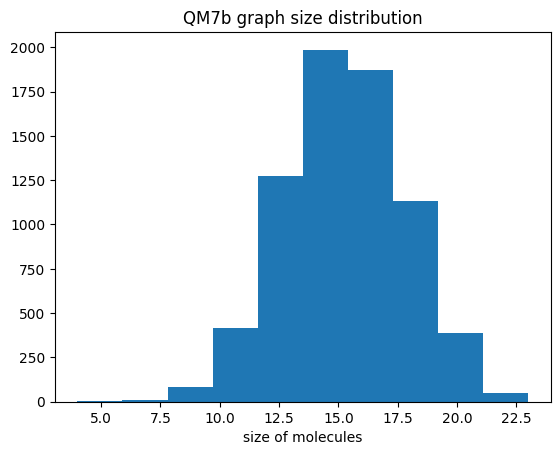

In [ ]:
plt.hist(sizes)
plt.xlabel("size of molecules")
plt.title("QM7b graph size distribution")
plt.show()

### Model
- Invariant feature map/extraction: $X \to (\{f^d \}, \{f^o \}, f^*)$
- Learn MLP(deep_set_1( $\{f^d \}$ , deep_set_2($\{f^d \}$), MLP_s($f^*$)), where
  - deep_set_i, MLP_s: input_dim = 1, output_dim = hid_dim
  - MLP: input_dim = hid_dim + hid_dim + hid_dim, output_dim = num_classes (invariant classification) / 1 (invariant scalar regression)
- Deepset, proposed in [Zaheer et al. ](https://arxiv.org/pdf/1703.06114.pdf), can universally approximate continuous functions on sets (where elements are from countable domain), by choosing suitable $\rho, \phi$, and maps a input set $X$ via
$$
\rho ( \sum_{x \in X} \phi(x) )
$$
We use the Deepset implementation in Pytorch Geometric, which can apply to batch of sets

WHY ARE WE BETTER?
- using Deepset to deal with the varying-size problem (not ad-hoc zero padding), which also minimizes memory storage and much lightweight
- only using 100 binary expansion (basis), also comparatively lightweight (few) compared to SOTA while giving good results
- [TBC] few-shot learning / low sample complexity

In [ ]:
class ScalarModel(torch.nn.Module):
    def __init__(self, hid_dim, out_dim, dropout=0, input_dim=1):
        super(ScalarModel, self).__init__()
        #Deepset for diagonal scalars
        phi_d = MLP([input_dim,hid_dim, hid_dim*2], dropout=[dropout]*2)
        rho_d = MLP([hid_dim*2, hid_dim], dropout=[dropout]*1) #MLP([hid_dim*2, hid_dim, hid_dim], dropout=[dropout]*2) #
        self.deepset_d = DeepSetsAggregation(local_nn=phi_d, global_nn=rho_d)
        #Deepset for off-diagonal scalars
        phi_o = MLP([input_dim,hid_dim, hid_dim*2], dropout=[dropout]*2)
        rho_o = MLP([hid_dim*2, hid_dim], dropout=[dropout]*1) #MLP([hid_dim*2, hid_dim, hid_dim], dropout=[dropout]*2) 
        self.deepset_o = DeepSetsAggregation(local_nn=phi_o, global_nn=rho_o) 
        #MLP_s for f_star
        self.MLP_s = MLP([input_dim,hid_dim, hid_dim], dropout=[dropout]*2)  #MLP([1,hid_dim*2, hid_dim], dropout=[dropout]*2) #
        #MLP for (Deepset(f_d), Deepset(f_o), f_star)
        self.MLP_out = MLP([hid_dim*3, hid_dim, out_dim], dropout=[dropout]*2)

    def reset_parameters(self):
        for net in [self.deepset_d, self.deepset_o, self.MLP_s, self.MLP_out]:
        #for net in [self.deepset_d, self.deepset_o, self.MLP_out]:
            net.reset_parameters()
    
    def forward(self, data):
        out_d = self.deepset_d(data.f_d, data.f_d_batch) # bs x hid_dim
        out_o = self.deepset_o(data.f_o, data.f_o_batch) # bs x hid_dim
        out_star = self.MLP_s(data.f_star) #bs x hid_dim
        #concat and output final embedding
        out = self.MLP_out(torch.concat([out_d, out_o, out_star], dim=-1)) # bs x hid_dim*3 -> bs x out_dim
        return out

#### Training

In [ ]:
#code adapated from https://github.com/nhuang37/untrain_MPNN/blob/main/GNN_untrained/auxiliarymethods/gnn_evaluation.py

def train(train_loader, model, optimizer, device):
    model.train()
    loss_all = 0

    lf = torch.nn.L1Loss()

    for data in train_loader:
        #print(data)
        data = data.to(device)
        optimizer.zero_grad()
        loss = lf(model(data), data.y)

        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return (loss_all / len(train_loader.dataset))


def test(loader, model, device, per_target=False):
    model.eval()
    out_dim = model.MLP_out.channel_list[-1]
    if per_target:
      error_pt = torch.zeros(out_dim)
    error = 0

    for data in loader:
        data = data.to(device)
        error_multi = (model(data) - data.y).abs()
        if per_target:
          error_pt += error_multi.sum(axis=0).cpu()

        error += error_multi.sum().item()
    if per_target:
      return error / len(loader.dataset), error_pt / len(loader.dataset)
    else:
      return error / len(loader.dataset), None


# 10-CV for NN training and hyperparameter selection.
def nn_evaluation(dataset, hid_dim, out_dim, max_num_epochs=200, batch_size=128, start_lr=0.01, min_lr = 0.000001, factor=0.5, patience=50,
                       num_repetitions=5, all_std=True, verbose=True, dropout=0, per_target=False):
    #reproducibility
    torch.manual_seed(0)

    # Set device.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    test_all = []
    test_complete = []

    # Input dim
    input_dim = dataset.data.f_star.shape[1]
    print(input_dim)

    for i in range(num_repetitions):
        # Test acc. over all folds.
        test_error = []
        kf = KFold(n_splits=10, shuffle=True, random_state=i)
        #dataset.shuffle()

        for train_index, test_index in kf.split(list(range(len(dataset)))):
            # Sample 10% split from training split for validation.
            train_index, val_index = train_test_split(train_index, test_size=0.1, random_state=i)
            best_val_error = None
            best_test = None

            # Split data.
            train_dataset = dataset[train_index.tolist()]
            val_dataset = dataset[val_index.tolist()]
            test_dataset = dataset[test_index.tolist()]

            # Prepare batching. (follow_batch: batchify both f_d, f_o)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, follow_batch=['f_d', 'f_o'])
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, follow_batch=['f_d', 'f_o'])
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, follow_batch=['f_d', 'f_o']) #reproducible

            # Collect val. and test acc. over all hyperparameter combinations.
            # Setup model.
            model = ScalarModel(hid_dim, out_dim, dropout, input_dim).to(device)
            #model = ScalarModel_Bessel(hid_dim, out_dim, dropout).to(device)
            model.reset_parameters()

            optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                    factor=factor, patience=patience,
                                                                    min_lr=0.0000001)
            for epoch in range(1, max_num_epochs + 1):
                lr = scheduler.optimizer.param_groups[0]['lr']
                loss = train(train_loader, model, optimizer, device)
                val_error, val_pt = test(val_loader, model, device, per_target)
                scheduler.step(val_error)

                if best_val_error is None or val_error <= best_val_error:
                    best_val_error = val_error
                    best_test, test_pt = test(test_loader, model, device, per_target)
                if verbose and (epoch+1) % 50 == 0:
                    print('Epoch: {:03d}, LR: {:.7f}, Loss: {:.4f},'
                      'Val MAE: {:.4f}'.format(epoch, lr, loss, val_error))
                # Break if learning rate is smaller 10**-6.
                if lr < min_lr:
                    break
            if per_target:
                print(f"per_target Val MAE = {val_pt}")
            test_error.append(best_test)
            print(f"Finish run with best_test={best_test:.4f}")
            if all_std:
                test_complete.append(best_test)
        test_all.append(float(np.array(test_error).mean()))

    if all_std:
        return (np.array(test_all).mean(), np.array(test_all).std(),
                np.array(test_complete).std())
    else:
        return (np.array(test_all).mean(), np.array(test_all).std())

In [ ]:
#Note: the basis transform scales linearly with the number of basis

In [ ]:
hid_dim = 512
out_dim = 1 #14
dropout = 0
batch_size = 128
max_num_epochs = 1000
min_lr = 0.0000001 #UPDATED
patience = 20 #UPDATED
mae, std, std_all = nn_evaluation(dataset, hid_dim, out_dim, batch_size=batch_size, max_num_epochs=max_num_epochs, 
                                  start_lr=0.02, min_lr = min_lr, factor=0.8, patience=patience,
                       num_repetitions=1, all_std=True, verbose=True, dropout=dropout)

100
Epoch: 049, LR: 0.0200000, Loss: 25.3624,Val MAE: 14.6548
Epoch: 099, LR: 0.0128000, Loss: 24.1583,Val MAE: 132.6890
Epoch: 149, LR: 0.0081920, Loss: 25.1029,Val MAE: 78.9177
Epoch: 199, LR: 0.0052429, Loss: 20.9481,Val MAE: 21.1522
Epoch: 249, LR: 0.0033554, Loss: 20.9012,Val MAE: 31.1724
Epoch: 299, LR: 0.0021475, Loss: 19.0874,Val MAE: 16.5821
Epoch: 349, LR: 0.0013744, Loss: 19.5101,Val MAE: 19.3185
Epoch: 399, LR: 0.0010995, Loss: 20.3932,Val MAE: 14.3973
Epoch: 449, LR: 0.0007037, Loss: 19.4771,Val MAE: 13.6790
Epoch: 499, LR: 0.0004504, Loss: 17.5787,Val MAE: 26.0331
Epoch: 549, LR: 0.0002882, Loss: 21.3642,Val MAE: 10.7732
Epoch: 599, LR: 0.0001476, Loss: 19.0149,Val MAE: 8.4480
Epoch: 649, LR: 0.0000944, Loss: 20.0332,Val MAE: 9.5044
Epoch: 699, LR: 0.0000604, Loss: 17.6751,Val MAE: 8.5911
Epoch: 749, LR: 0.0000484, Loss: 20.8252,Val MAE: 8.1631
Epoch: 799, LR: 0.0000248, Loss: 20.3293,Val MAE: 7.9869
Epoch: 849, LR: 0.0000158, Loss: 18.4630,Val MAE: 7.2925
Epoch: 899, LR:

In [ ]:
hid_dim = 256
out_dim = 1 #14
dropout = 0
batch_size = 128
max_num_epochs = 1000
min_lr = 0.0000001 #UPDATED
patience = 20 #UPDATED
mae, std, std_all = nn_evaluation(dataset, hid_dim, out_dim, batch_size=batch_size, max_num_epochs=max_num_epochs, 
                                  start_lr=0.02, min_lr = min_lr, factor=0.8, patience=patience,
                       num_repetitions=1, all_std=True, verbose=True, dropout=dropout)

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


100
Epoch: 049, LR: 0.0200000, Loss: 28.6855,Val MAE: 227.5056
Epoch: 099, LR: 0.0128000, Loss: 23.7137,Val MAE: 46.0820
Epoch: 149, LR: 0.0081920, Loss: 20.4971,Val MAE: 118.2099
Epoch: 199, LR: 0.0041943, Loss: 20.5522,Val MAE: 358.0986
Epoch: 249, LR: 0.0033554, Loss: 20.1862,Val MAE: 25.9182
Epoch: 299, LR: 0.0017180, Loss: 21.7859,Val MAE: 10.9584
Epoch: 349, LR: 0.0010995, Loss: 21.3241,Val MAE: 8.5966
Epoch: 399, LR: 0.0007037, Loss: 22.5786,Val MAE: 17.7308
Epoch: 449, LR: 0.0005629, Loss: 20.0262,Val MAE: 15.2174
Epoch: 499, LR: 0.0003603, Loss: 20.9693,Val MAE: 7.9936
Epoch: 549, LR: 0.0002306, Loss: 19.4646,Val MAE: 11.3357
Epoch: 599, LR: 0.0001845, Loss: 22.0336,Val MAE: 8.4630
Epoch: 649, LR: 0.0001181, Loss: 19.8118,Val MAE: 8.5338
Epoch: 699, LR: 0.0000756, Loss: 20.8628,Val MAE: 7.6221
Epoch: 749, LR: 0.0000387, Loss: 20.1285,Val MAE: 7.6349
Epoch: 799, LR: 0.0000248, Loss: 17.1195,Val MAE: 7.5699
Epoch: 849, LR: 0.0000158, Loss: 18.2042,Val MAE: 7.6960
Epoch: 899, LR:

#### Comparison with related work 
- (A slight different/easier dataset QM7, same Colomb Matrix (CM) representation):
 -  [Rupp et al.](https://arxiv.org/pdf/1109.2618.pdf) achieved Atomization Energies MAE ~10 (target_variable=0), using eigenvalues of CM; 
 - [Montavon et al.](https://proceedings.neurips.cc/paper/2012/file/115f89503138416a242f40fb7d7f338e-Paper.pdf) achieve Atomization Energies MAE < 4 using random permutations (of rows and columns) of CM. It suggests that building an (approximate) equivariant model with data augmentation yields better performance (than exact invariant model, i.e., using eigenvalues)
- QM7b:
 - [Motavon et al.[https://th.fhi-berlin.mpg.de/site/uploads/Publications/QM-NJP_20130315.pdf]: Table 1 (really good results but require high memory storage, by first converting CM to binary representation (2000 x 23 x 23) Tensor
 - [Wu et al.](https://arxiv.org/pdf/1703.00564.pdf): Table 10 (similar to ours but use Kernel-ridge-regression for CM)

More refs: http://quantum-machine.org/datasets/
Better representation than CM: https://aip.scitation.org/doi/10.1063/1.5126701
(out of the scope?) (maybe can ask Erik if we go down the rabbit hole of this?)

### (Invariant classification) Benchmark dataset: ModelNet40
- The most popular dataset for pointcloud classification
- Can benchmark against Deepset and PointNet (old SOTA models): e,g, https://github.com/manzilzaheer/DeepSets/blob/master/PointClouds/run.py
- BUG: relatively large point clouds, our methods need $O(n^2)$ computation whereas Deepset/PointNet can do $O(n)$ (since the point clouds literally live in $d=3$)